### Decision Trees

A decision tree is essentially a flow chart for deciding how to classify an observation: it consists of a series of yes/no or if/else decisions that ultimately assign each observation to a certain probability or class. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
titanic_train = pd.read_csv("titanic_train.csv")    # Read the data

# Impute median Age for NA Age values
new_age_var = np.where(titanic_train["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       titanic_train["Age"])     # Value if check is false

titanic_train["Age"] = new_age_var 

In [3]:
from sklearn import tree
from sklearn import preprocessing

In [4]:
# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# Convert Sex variable to numeric
encoded_sex = label_encoder.fit_transform(titanic_train["Sex"])

# Initialize model
tree_model = tree.DecisionTreeClassifier()

# Train the model
tree_model.fit(X = pd.DataFrame(encoded_sex), 
               y = titanic_train["Survived"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [5]:
# Save tree as dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(tree_model, 
                              feature_names=["Sex"], 
                              out_file=f)

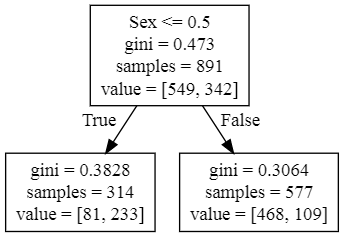

In [12]:
from IPython.display import Image
Image("tree1.png")               # Display image*

The tree's graph shows that it consists of only one decision node that splits the data on the variable sex. All 312 females end up in one leaf node and all 577 males end up in a different leaf node.

In [13]:
# Get survival probability
preds = tree_model.predict_proba(X = pd.DataFrame(encoded_sex))

pd.crosstab(preds[:,0], titanic_train["Sex"])

Sex,female,male
row_0,,
0.257962,314,0
0.811092,0,577


Let's create a new decision tree that adds the passenger class variable and see how it changes the resulting predictions:

In [15]:
# Make data frame of predictors
predictors = pd.DataFrame([encoded_sex, titanic_train["Pclass"]]).T

# Train the model
tree_model.fit(X = predictors, 
               y = titanic_train["Survived"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [16]:
with open("tree2.dot", 'w') as f:
     f = tree.export_graphviz(tree_model, 
                              feature_names=["Sex", "Class"], 
                              out_file=f)

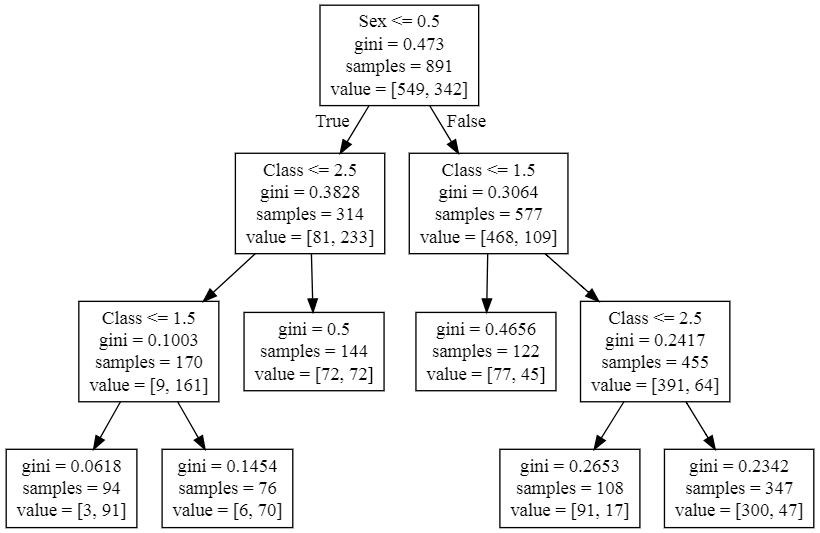

In [17]:
Image("tree2.png")  

In [18]:
# Get survival probability
preds = tree_model.predict_proba(X = predictors)

# Create a table of predictions by sex and class
pd.crosstab(preds[:,0], columns = [titanic_train["Pclass"], 
                                   titanic_train["Sex"]])

Pclass        1           2           3     
Sex      female male female male female male
row_0                                       
0.031915     94    0      0    0      0    0
0.078947      0    0     76    0      0    0
0.500000      0    0      0    0    144    0
0.631148      0  122      0    0      0    0
0.842593      0    0      0  108      0    0
0.864553      0    0      0    0      0  347

In [19]:
tree_model.score(X = predictors, 
                 y = titanic_train["Survived"])

0.78675645342312006

### Holdout Validation and Cross Validation

In [20]:
from sklearn.cross_validation import train_test_split

C:\Users\mbelkhei\AppData\Local\Continuum\Anaconda2\envs\ztdl\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
v_train, v_test = train_test_split(titanic_train,     # Data set to split
                                   test_size = 0.25,  # Split ratio
                                   random_state=1,    # Set random seed
                                   stratify = titanic_train["Survived"]) #*

# Training set size for validation
print(v_train.shape)
# Test set size for validation
print(v_test.shape)

(668, 12)
(223, 12)



*Note: When performing classification, it is desirable for each class in the target variable to have roughly the same proportion across each split of the data. The stratify argument lets you specify a target variable to spread evenly across the train and test splits.

In [23]:
from sklearn.cross_validation import KFold

cv = KFold(n=len(titanic_train),  # Number of elements
           n_folds=10,            # Desired number of cv folds
           random_state=12)       # Set a random seed

In [24]:
fold_accuracy = []

titanic_train["Sex"] = encoded_sex

for train_fold, valid_fold in cv:
    train = titanic_train.loc[train_fold] # Extract train data with cv indices
    valid = titanic_train.loc[valid_fold] # Extract valid data with cv indices
    
    model = tree_model.fit(X = train[["Sex","Pclass","Age","Fare"]], 
                           y = train["Survived"])
    valid_acc = model.score(X = valid[["Sex","Pclass","Age","Fare"]], 
                            y = valid["Survived"])
    fold_accuracy.append(valid_acc)    

print("Accuracy per fold: ", fold_accuracy, "\n")
print("Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))

Accuracy per fold:  [0.78888888888888886, 0.797752808988764, 0.7191011235955056, 0.7528089887640449, 0.797752808988764, 0.8202247191011236, 0.8089887640449438, 0.7752808988764045, 0.8089887640449438, 0.84269662921348309] 

Average accuracy:  0.791248439451



Model accuracy can vary significantly from one fold to the next, especially with small data sets, but the average accuracy across the folds gives you an idea of how the model might perform on unseen data.
As with holdout validation, we'd like the target variable's classes to have roughly the same proportion across each fold when performing cross validation for a classification problem. To perform stratified cross validation, use the StratifiedKFold() function instead of KFold().

In [25]:
from sklearn.cross_validation import cross_val_score


In [26]:
scores = cross_val_score(estimator= tree_model,     # Model to test
                X= titanic_train[["Sex","Pclass",   # Train Data
                                  "Age","Fare"]],  
                y = titanic_train["Survived"],      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print(scores)
print("Average accuracy: ", scores.mean())

Accuracy per fold: 
[ 0.78888889  0.75555556  0.75280899  0.7752809   0.82022472  0.7752809
  0.84269663  0.79775281  0.78651685  0.84090909]
Average accuracy:  0.793591533311
